# Assigment 3


## Upload your code on Learn dropbox and submit pdfs of the code and answers to the mathematical questions on Crowdmark.

## -----------------------------------------------------------------------------------------------------------

## Load modules

In [29]:
# !pip install numpy, scipy, scikit-image, skimage, matplotlib

import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage import data
from skimage.transform import resize

# Numpy is useful for handling arrays and matrices.
import numpy as np

# my import 
from numpy.linalg import norm
import math
import time
from scipy import real, ndimage



## Load image

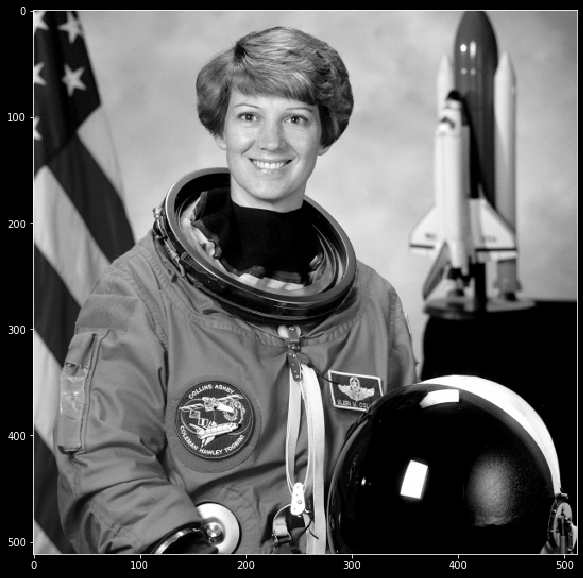

In [30]:
img = data.astronaut()
img = rgb2gray(img)*255 # convert to gray and change scale from (0,1) to (0,255).

n = img.shape[0]

plt.figure(1, figsize=(10, 10))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

## Compute the differences operators here. Use your code from Assignment 2.

In [31]:
# You will need these three methods to construct sparse differences operators.
# If you do not use sparse operators you might have scalability problems.
from scipy.sparse import diags
from scipy.sparse import kron
from scipy.sparse import identity


# Use your code from Assignment 2. 
# Make sure that you compute the right D_h and D_v matrices.

## Add noise to the image

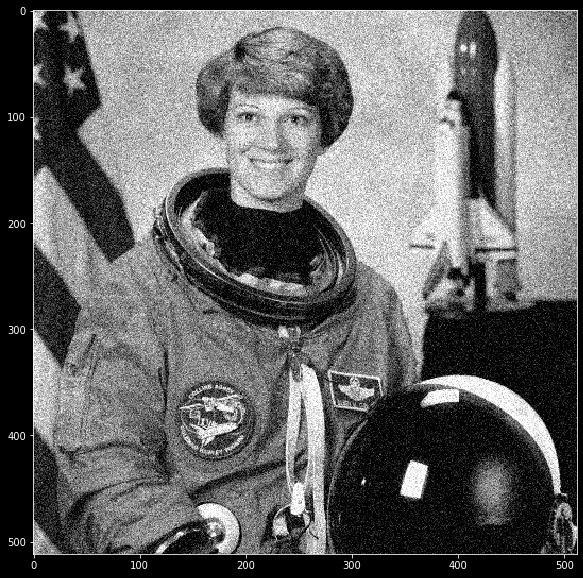

In [32]:
mean_ = 0
standard_deviation = 30
dimensions = (n,n)

noise = np.random.normal(mean_,standard_deviation,dimensions)

noisy_image = img + noise

plt.figure(1, figsize=(10, 10))
plt.imshow(noisy_image, cmap='gray', vmin=0, vmax=255)
plt.show()

In [7]:
m = noisy_image.shape[0] # ROWS
n = noisy_image.shape[1] # COLS


I = diags([1], [0],shape=(n,n),dtype='int8')
J = diags([-1,1],[0,1],shape=(m,m),dtype='int8')
Dh = kron(J, I)
Dv = kron(I, J)

D = Dh+ 1j*Dv
x0 = noisy_image.flatten('F')

## Question 1 (8 marks): implement gradient descent with Armijo line-search for the Total-Variation denoising problem. Use the pseudo-Huber function to smooth the problem. 

In [33]:
# Write your code here.
# gradient descent with Armijo line-search for the Total-Variation denoising
def gradient_descent_armijo(x0, epsilon, lambda_, max_iterations,gamma_, mu_,clean_image):
    # initialize variables, x and grad, list of x and grad
    counter = 0
    x = x0
    xs = [x]
    D = Dh + 1J * Dv
    # phi_Dx =  sum( ((miu_**2 - dxi**2)**(1/2)-miu_) for dxi in Dx)
    grad = calculate_gradient_fx(x, x0, lambda_, mu_)
    grads = [grad]
    while counter < max_iterations and norm(grad,2) > epsilon:
        alpha_ = line_search_Armijo(x, x0, grad, gamma_, lambda_, mu_)
        x = x - alpha_ * grad
        old_grad = grad
        grad = calculate_gradient_fx(x, x0, lambda_, mu_)
        xs.append(x)
        grads.append(grad)
        counter += 1

        old_grad_norm = norm(old_grad,2)
        grad_norm = norm(grad,2)
        if (abs(grad_norm - old_grad_norm)/old_grad_norm) < 0.01:
            print('gradient changes less than 1%, stop here')
            break
        # print iteration, norm of gradient and the norms of noisy
        print(counter, grad_norm, 1/n**2 * norm(x-clean_image, 2))
    return xs, grads

# helper function, take x, return gradient of f(x)
def calculate_gradient_fx(x, x0, lambda_, mu_):
    
    Dhx = Dh@x
    Dvx = Dv@x
    d = (mu_ ** 2 + Dhx ** 2 +  Dvx ** 2) ** (-0.5)
    grad = lambda_ * (Dv.transpose()@(Dvx * d) + Dh.transpose()@(Dhx * d)) +  x - x0
    return grad

# line search armijo 
def line_search_Armijo(x, x0, grad, gamma_, lambda_, mu_):
    # counter and initial guess
    counter = 0
    alpha_ = 1
    diff = x - alpha_ * grad
    # store the value for re-use
    deno_x = denoising_tv(x, x0, lambda_, mu_)
    LHS = denoising_tv(diff, x0, lambda_, mu_)
    RHS = deno_x - alpha_ * gamma_ * norm(grad, 2) ** 2
    while LHS > RHS:
        alpha_ /= 2
        diff = x - alpha_ * grad
        LHS = denoising_tv(diff, x0, lambda_, mu_)
        RHS = deno_x - alpha_ * gamma_ * norm(grad) ** 2
        counter += 1
    return alpha_

# total variation denoising 
# return fx = lambda *phi(Dx) + 1/2 * ||x - z_noisy||2^2
def denoising_tv(x,x0,lambda_,mu_):
    Dx = D@x
    mu_sq = math.pow(mu_,2)
    def tv_d(i):
        return (abs(i) ** 2 + mu_sq) ** 0.5 - mu_
    pesudo_huber = sum(map(tv_d, Dx))
    return pesudo_huber * lambda_ + 0.5 * math.pow(norm(x - x0, 2),2)





## Call Gradient Descent with Armijo line-search to denoise the image. Parameter tunning is not given for this assignment. You will have to tune all parameters yourself. Regarding the quality of the output image, pick the $\lambda$ parameter that makes the error $$\frac{1}{n^2}\|z_{output} - z_{clean}\|_2$$ as small as possible, where $z_{output}$ is the output of the algorithm. Find $\lambda$ by trial and error. Note that the smoothing parameter $\mu$ affects the quality of the output as well. Pick $\mu$ small enough such that the above error does not improve much for smaller values of $\mu$. I will measure the running time only for your chosen parameters $\lambda$ and $\mu$, therefore, make sure to seperate any code that does trial and error and the code that reports the result for the chosen parameters.

In [10]:
lambda_ = 20
epsilon = 1.0e-2
max_iterations = 2000
gamma_ = 0.15
mu_ = 1.0e-2
max_iterations = 100

# Write your code here.
x0 = noisy_image.flatten('F')
clean_image = img.flatten('F')
s = time.time()
xal_list, norm_list = gradient_descent_armijo(x0, epsilon, lambda_, max_iterations, gamma_, mu_,clean_image)
e = time.time()
print(e-s)

als_list = np.reshape(xal_list[len(xal_list)-1], (n, n), order='F')

fig = plt.figure(2, figsize=(10, 10))
plt.imshow(als_list, cmap='gray', vmin=0, vmax=255)

plt.show()

1 19878.620761694405 0.034215971769515456
2 15026.602293643999 0.029857706937724694
3 9473.946252006783 0.02741825376758558
4 9584.940010878303 0.02588398631047504
5 7482.506704533938 0.02527661802905074
6 8079.923665379031 0.024768078012628276


KeyboardInterrupt: 

## Question 2 (5 marks): implement gradient descent with simple line-search for the Total-Variation denoising problem. Use the pseudo-Huber function to smooth the problem.

In [34]:
# Write your code here.

def line_search_simple(x, x0, grad, gamma_, lambda_, mu_):
    alpha_=1
    diff = x - alpha_ * grad
    RHS = denoising_tv(x, x0, lambda_, mu_)
    LHS = denoising_tv(diff, x0, lambda_, mu_)
    # RHS = deno_x - alpha_ * gamma_ * norm(grad, 2) ** 2
    while LHS >= RHS:
        alpha_ = alpha_ / 2
        diff = x - alpha_ * grad
        LHS = denoising_tv(diff, x0, lambda_, mu_)
#         RHS does not change
#         RHS = denoising(x)    #!!! this step significantly changes the time consumed!!!!!!!!.
    return alpha_

def gradient_descent_simple(x0, epsilon, lambda_, max_iterations,gamma_, mu_,clean_image):
    # initialize variables, x and grad, list of x and grad
    counter = 0
    x = x0
    xs = [x]
    D = Dh + 1J * Dv
    # phi_Dx =  sum( ((miu_**2 - dxi**2)**(1/2)-miu_) for dxi in Dx)
    grad = calculate_gradient_fx(x, x0, lambda_, mu_)
    grads = [grad]
    while counter < max_iterations and norm(grad,2) > epsilon:
        alpha_ = line_search_simple(x, x0, grad, gamma_, lambda_, mu_)
        x = x - alpha_ * grad
        old_grad = grad
        grad = calculate_gradient_fx(x, x0, lambda_, mu_)
        xs.append(x)
        grads.append(grad)
        counter += 1

        old_grad_norm = norm(old_grad,2)
        grad_norm = norm(grad,2)
        if (abs(grad_norm - old_grad_norm)/old_grad_norm) < 0.01:
            print('gradient changes less than 1%, stop here')
            break
        # print iteration, norm of gradient and the norms of noisy
        print(counter, grad_norm, 1/n**2 * norm(x-clean_image, 2))
    return xs, grads

## Call gradient descent with simple line-search to denoise the image. Use the same $\lambda$ and $\mu$ that you used in Q1. 

In [0]:
# write your code here

lambda_ = 20
epsilon = 1.0e-2
max_iterations = 2000
gamma_ = 0.15
mu_ = 1.0e-2
max_iterations = 100

# Write your code here.
x0 = noisy_image.flatten('F')
clean_image = img.flatten('F')
s = time.time()
xal_list, norm_list = gradient_descent_simple(x0, epsilon, lambda_, max_iterations, gamma_, mu_,clean_image)
e = time.time()
print(e-s)

als_list = np.reshape(xal_list[len(xal_list)-1], (n, n), order='F')

fig = plt.figure(2, figsize=(10, 10))
plt.imshow(als_list, cmap='gray', vmin=0, vmax=255)

plt.show()

## Question 3 (6 marks): Compute a Lipschitz constant for the smoothed Total-Variation problem. Note the Lipschitz constant is not unique. However, the minimum Lipschitz constant will give you better performance in algorithms compared to larger Lipschitz constants. This means that whatever you compute here will affect the running time of your algorithm in Q4.

In [35]:
from scipy.sparse import vstack
from scipy.sparse.linalg import eigsh, svds
A = vstack((Dh,Dv))
print(type(A))
A = A.asfptype()
eigv = eigsh(A.transpose().dot(A), 1,which='LM', return_eigenvectors=False)
# eigv = ||Z||_2^2
print(eigv)
L_mu = eigv / mu_
# the lipschitz constant
L = lambda_*L_mu+1
print(L)

# eigv = ||Z||_2^2 =7.99996
#L=16000.843




<class 'scipy.sparse.coo.coo_matrix'>
[7.9999623]
[16000.926]


## Question 4 (8 marks): implement accelerated gradient for the Total-Variation denoising problem. Use the pseudo-Huber function to smooth the problem. Use the Lipschitz constant that you obtained in Q3. Do not include computation of the Lipschitz constant in this question. You can do it in Q3 and the time for computing the Lipschitz constant will not be taken into account.

In [37]:

# eigv = ||Z||_2^2 =7.99996
# L=16000.843
# when taking lambda_ = 20 amd mu_ = 1e-2


# def accelerate_method(x, z, x0, i, L, lambda_k, lambda_,mu_):
#     if ( i <=3):
#         r = 0
#     else:
#         r = 2 / i
#     lambda_k = lambda_k*(1-r)
#     y = (1 - r) * x + r * z
#     grad_y = calculate_gradient_fx(x, x0, lambda_, mu_)
#     z = z - (r / lambda_k) * grad_y
#     x = y - 1 / L * grad_y
#     return x, z, lambda_k

# def accelerated_gradient_descent(x0, epsilon,lambda_, max_iterations, mu, z_clean):
#     print('accelerated_gradient_descent')
#     start = time.clock()
#     x = x0
#     xs = [x]
#     counter = 0
#     grad = calculate_gradient_fx(x, x0, lambda_, mu_)
#     old_grad = grad
#     L = 16000
#     z = x0
#     lambda_k = 1
#     old_grad = grad
#     L = 16000
#     z = x0
#     lambda_k = 1
#     old_norm = norm(old_grad,2)
#     new_norm = norm(grad,2)
#     print(type(counter))
#     print(type(max_iterations))
#     while counter < max_iterations and new_norm > epsilon and new_norm < 1.1*old_norm:
#         x,z, lambda_k = accelerate_method(x,z,x0,counter, L, lambda_k, lambda_, mu_)
#         old_grad = grad
#         grad = calculate_gradient_fx(x, x0, lambda_, mu_)

#         old_norm = norm(old_grad,2)
#         new_norm = norm(grad,2)
#         xs.append(x)
#         counter +=1
#         print(counter, norm(grad,2), 1/n**2 * norm(x-z_clean,2))
#     duration = (time.clock() - start)
#     return xs[:-1]


def line_search_sls(x, x0, grad, gamma_, lambda_, mu_, alpha_=1):
    x1 = x - alpha_ * grad
    lhs = tv_denoising(x1, x0, lambda_, mu_)
    rhs = tv_denoising(x, x0, lambda_, mu_)
    while lhs >= rhs:
        alpha_ /= 2
        x1 = x - alpha_ * grad
        lhs = tv_denoising(x1, x0, lambda_, mu_)
    return alpha_

def gradient_descent_sls(x0, epsilon, lambda_, max_iterations, gamma_, mu_, z_clean):
    cur_i = 0
    x = x0
    x_list = []
    x_list.append(tv_denoising(x, x0, lambda_, mu_))
    grad = tv_denoising_gradient(x, x0, lambda_, mu_)
    while norm(grad, 2) > epsilon and cur_i < max_iterations:
        alpha = line_search_sls(x, x0, grad, gamma_, lambda_, mu_)
        x = x - alpha * grad
        grad = tv_denoising_gradient(x, x0, lambda_, mu_)
        x_list.append(tv_denoising(x, x0, lambda_, mu_))
        cur_i += 1
#         print(cur_i, norm(grad, 2), 1/n**2 * norm(x-z_clean, 2))
    print("Error: ", 1/n**2 * norm(x-z_clean, 2))
    return x_list


## Call accelerated gradient to denoise the image. Use the same $\lambda$ and $\mu$ that you used in Q1.

In [38]:
# x0 = noisy_image.flatten('F')
# clean_image = img.flatten('F')
# s = time.time()
# x_list = accelerated_gradient_descent(x0, epsilon, lambda_, max_iterations, mu_,clean_image)
# e = time.time()
# print(e-s)

# a_list = np.reshape(x_list[len(x_list)-1], (n, n), order='F')

# fig = plt.figure(2, figsize=(10, 10))
# plt.imshow(a_list, cmap='gray', vmin=0, vmax=255)

# plt.show()
s = time.time()
obj_list2 = gradient_descent_sls(x0, epsilon, lambda_, max_iterations, gamma_, mu_, z_clean)
e = time.time()
print(e-s)

NameError: name 'z_clean' is not defined

## Question 5 (10 marks): in Q4 you were asked to implement accelerated gradient by using constant step-sizes $1/L.$ However, computing the Lipschitz constant might take a lot of time and it often results in slow convergence because the step-sizes are too small. Below I give you a practical accelerated method that does not require knowing the Lipschitz constant. The step-sizes $$\alpha_k$$ in this algorithm can be computed using Armijo line-search. Implement this algorithm for the Total-Variation denoising problem. Use the pseudo-Huber function to smooth the problem. 

Step 1) Choose an $x_0$ and set $y_1=x_0$, $t_1=1$.

Step 2) Repeat the following steps until $\|\nabla f(x_k)\|_2\le \epsilon$

Step 3) Compute $\alpha_k$ using Armijo line-search. Armijo line-search should be measured at $y_k-\alpha_k \nabla f(y_k)$ (as the next point) and $y_k$ (as the current point).

Step 4) Set $$x_{k}=y_k - \alpha_k \nabla f(y_k)$$

Step 5) Set $$t_{k+1}=\frac{1 + \sqrt{1+4t_k^2}}{2}$$

Step 6) Set $$y_{k+1}=x_k + \frac{t_k-1}{t_{k+1}}(x_k-x_{k-1})$$

Reference: this algorithm is given in "A Fast Iterative Shrinkage-Thresholding Algorithm for Linear Inverse Problems" by A. Beck and M. Teboulle.
===================== 

In [0]:
# Write your code here
# line search armijo 
def line_search_Armijo_Q5(x, x0, grad, gamma_, lambda_, mu_):
    # counter and initial guess
    counter = 0
    alpha_ = 1
    diff = x - alpha_ * grad
    # store the value for re-use
    deno_x = denoising_tv(x, x0, lambda_, mu_)
    LHS = denoising_tv(diff, x0, lambda_, mu_)
    RHS = deno_x - alpha_ * gamma_ * norm(grad, 2) ** 2
    while LHS > RHS:
        alpha_ /= 2
        diff = x - alpha_ * grad
        LHS = denoising_tv(diff, x0, lambda_, mu_)
        RHS = deno_x - alpha_ * gamma_ * norm(grad) ** 2
        counter += 1
    return alpha_

## Call the practical accelerated gradient to denoise the image. Use the same $\lambda$ and $\mu$ that you used in Q1.

In [0]:
# Write your code here

## Question 6 (5 marks): Compare all the methods that you implemented above. Make a plot where in the y-axis is the value of the smoothed objective function and in the x-axis the number of iterations. Compare the methods using the same $\lambda$ and $\mu$ that you used in Q1.

In [0]:
# Write your code here.

## Question 7 (8 marks): Illustrate the trade-off between the number of iterations and the smoothing parameter $\mu$ for gradient descent with Armijo line-search and accelerated gradient with Armijo line-search. Do this by plotting the number of iterations (y-axis) vs magnitude of parameter $\mu$ (x-axis in ascending order). Start from a small $\mu$ and increase it gradually. Plot the result for both methods in the same plot. Use appropriate legends for the plot.

In [0]:
# Write your code here.

## Mathematical Questions

## Question 8 (5 marks): Derive a smooth approximation (Huber function) of the L1-norm using the convex conjugate of the L1-norm and the distance function $$d(y)=\frac{1}{2}\|y\|_2^2.$$

## Question 9 (7 marks): Derive the pseudo-Huber function using the convex conjugate of the L1-norm.  To derive the pseudo-Huber use the distance function $$d(y)=\sum_{i=1}^n 1 - \sqrt{1-y_i^2}$$ with domain $$|y_i|\le 1 \ \ \forall i.$$

## Question 10 (3 marks): Show that the pseudo-Huber function is convex and not strongly-convex.

## Question 11 (7 marks): If the convex conjugate of $f$ is strongly-convex with compact convex domain then $$\max_{y \in \mbox{dom} \ f^*} x^Ty - f^*(y)$$ has a unique maximizer. Show that  $$\nabla f(x) =\mbox{argmax}_{y \in \mbox{dom} \ f^*} x^Ty - f^*(y).$$ Hint: one approach to solve this is to lower and upper bound $f$ and then use the definition of directional derivative.

## Question 12 (7 marks): Prove that if the convex conjugate of $f$ is $\delta$-strongly-convex, then $\nabla f(x)$ is Lipschitz continuous with Lipschitz constant $1/\delta.$

## Question 13 (8 marks):  Assume that the domain of the convex conjugate satisfies $$\mbox{dom} \ f^* \subseteq \mathbb{R}^n.$$ and it is closed and bounded. You are given a continuous distance function $d(y)$ where its domain satisfies $$\mbox{dom} \ f^* \subseteq \mbox{dom} \ d .$$ Prove that $$f(x) - \mu D \le f_\mu(x) \le f(x),$$ where $D$ has to be bounded and $f_\mu(x)$ is the smooth approximation of $f$. See slides 54-57 in Lecture07and08 on piazza. Hint: you will need the Weierstrass extreme value theorem to show that $D$ is bounded.

## ## Question 14 (8 marks): We proved that for any convex function with Lipschitz continuous gradient there exists and estimate sequence. Show that for an estimate sequence we have that $$f(x_k) - f^* = \mathcal{O}\left(\frac{1}{k^2}\right)$$

## Question 15 (5 marks): Obtain the convergence rate and iteration complexity for the accelerated method for strongly-convex functions with Lipschitz continuous gradient.